In [1]:
import random
import numpy as np
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

#### Network

In [2]:
class Network:
    
    def __init__(self, n):
        self.nodes = [Individual(i) for i in range(n)]
        self.edges = {}
    
    def create_erdos_graph(self, n, p):
        """
        n : Number of nodes
        p : Probability of there being a edge between any two nodes
        Adds links/edges as per erdos renyi graph
        """
        edge_count = 0
        for i in range(n):
            for j in range(i+1, n):
                if(random.random() < p):
                    temp = Connection(edge_count, [self.nodes[i], self.nodes[j]])
                    self.edges[(self.nodes[i].id, self.nodes[j].id)] = temp
    
    def create_from_networkx(self, G):
        """
        G : networkx Graph Object
        Adds links/edges using networkx Graph Object
        """
        for count, (i, j) in enumerate(G.edges):
            temp = Connection(count, [self.nodes[i], self.nodes[j]])
            self.edges[(self.nodes[i].id, self.nodes[j].id)] = temp

    def get_edge(self, u, v):
        """
        u, v : 'Individual' object i.e. nodes
        returns Connection object if edge is present between given two nodes.
        """
        connection = self.edges.get((u.id,v.id), self.edges.get((v.id,u.id)))
        if connection is not None:
            return connection
        else:
            raise Exception('Edge Not Present')
     
    def propagate(self, sourse, info):
        """
        sourse : node of the network (Instance of class Individual)
        info   : information opinion score
        
        Information is passed through the network starting with 'sourse' node,
        as per 'Prasetya and Murata' model.
        """

        t = 0
        A   = {t: set((sourse,))} # set of active nodes(capable of passing the information).
        Inf = A[t].copy() #set of Infected nodes.

        while A[t] != set():
            A[t+1] = set()

            for active in A[t]:
                neighbors = set(active.neighbors)
                
                # all the neighbors which are not already Infected are potential targets
                for unInf in neighbors.difference(Inf):
                    connection = self.get_edge(active, unInf)

                    if random.random() < self.__P_uv__(active, unInf, info):
                        #print('Info-passed')
                        # Neighbor become infected and active
                        Inf.add(unInf)
                        A[t+1].add(unInf)

                        # Opinion shifts and connection strengthens
                        unInf.update(eta, info)
                        connection.update(eta)
                    else:
                        #print("Info-not-Pass")
                        connection.update(-eta)
            t += 1

    def __P_uv__(self, u, v, info):
        """
        u, v : 'Individual' object i.e. nodes
        info :  information opinion score

        returns probability of propagation
        """
        q = v.opinion
        c_uv = network.get_edge(u, v).strength
        p_uv = c_uv * c_uv + (1 - c_uv) * (1 - self.__logistic__(abs(info-q)/2))
        return p_uv        


    def __logistic__(self, x):
        B    = 10
        mu   = 0.15
        func = 1/(1 + np.exp(-B*(x-mu)))
        return func

    
    def calculate_opinion_polarization(self):
        """
        returns m‐value & q-absolute for the network
        """
        op = [each.opinion for each in self.nodes]
        hist, bins = np.histogram(op)
        
        m_val = 0
        for i in range(1,len(hist)):
            m_val += abs(hist[i] - hist[i-1])
        m_val /= max(hist)
        
        q_abs = np.mean(np.abs(op))
        
        return m_val, q_abs

    def calculate_links_polarization(self):
        """
        returns Edge Homogeneity for the network
        """
        num, den = 0, 0
        for key, val in self.edges.items():
            qu  = self.nodes[key[0]].opinion
            qv  = self.nodes[key[1]].opinion
            cuv = val.strength

            num += qu*qv*cuv
            den += cuv

        edge_hom = num/den
        return edge_hom
    
    def get_histograms(self):
        op = [each.opinion for each in self.nodes]
        op_hist = [list(each) for each in np.histogram(op)]
        
        st = [each.strength for each in self.edges.values()]
        st_hist = [list(each) for each in np.histogram(st)]
        
        return op_hist, st_hist
        
    def visualize(self):
        """
        Plots distributions for Individual-Opinion & Connection-Strength for the network
        """
        fig, ax = plt.subplots(1,2, figsize=(12,5))

        op = [each.opinion for each in self.nodes]
        sns.distplot(op, ax=ax[0], kde=False, bins=51).set_title('Individual-Opinion')
        ax[0].set_xlim((-1,1))
        plt.plot()

        st = [each.strength for each in self.edges.values()]
        sns.distplot(st, ax=ax[1], kde=False, bins=51).set_title('Connection-Strength')
        ax[1].set_xlim((0,1))
        plt.plot()

#### Individual

In [3]:
class Individual:
    
    def __init__(self, id):
        self.id = id
        self.opinion = (-1 + 2 *random.random())
        self.neighbors = []
    
    def update(self, eta, info):
        """
        eta  : update rate (parameter)
        info : information opinion score
        
        update opinion based on infromation, prior opinion and eta.
        """
        self.opinion = np.clip((self.opinion + eta * np.sign(info - self.opinion)), -1, 1)
        pass

#### Connection

In [4]:
class Connection:
    
    def __init__(self, id, nodes):
        self.id = id
        self.nodes = nodes
        self.nodes[0].neighbors.append(self.nodes[1])
        self.nodes[1].neighbors.append(self.nodes[0])
        self.strength = random.random()/2
    
    def update(self, delta):
        """
        Update Connection Strength with given delta.
        """
        self.strength = np.clip((self.strength+delta), 0, 1)

#### Random Graph

In [5]:
n = 250
network = Network(n)

In [6]:
p = 0.075
network.create_erdos_graph(n, p)

#### Run model

In [7]:
T = 10000
alpha = beta = 0.2

I = -1 + 2*stats.beta.rvs(alpha, beta, size=T)
S = random.choices(network.nodes, k = T)

eta = 0.01

In [8]:
for i in range(len(I)):
    network.propagate(S[i], I[i])

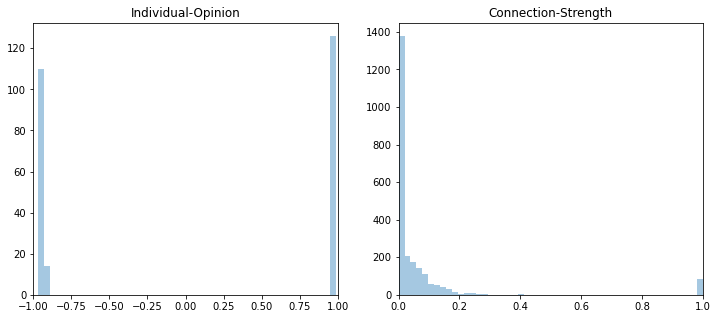

In [10]:
network.visualize()

In [11]:
m_val, q_abs = network.calculate_opinion_polarization()
print('m-value:',np.round(m_val,2),'&','q-absolute:',np.round(q_abs,2))

m-value: 1.98 & q-absolute: 0.96


In [12]:
edge_hom = network.calculate_links_polarization()
print('edge-homogenity:',np.round(edge_hom,2))

edge-homogenity: 0.92


#### visualization

In [13]:
G = nx.Graph()
G.add_edges_from(network.edges.keys())

In [14]:
nx.set_node_attributes(G, values={key.id:key.opinion for key in network.nodes}, name='opinion')
nx.set_edge_attributes(G, values={key:val.strength for key, val in network.edges.items()}, name='strength')

In [15]:
pos = nx.spring_layout(G, seed=2, weight='strength')

opinion_dic  = nx.get_node_attributes(G, 'opinion')
strength_dic = nx.get_edge_attributes(G, 'strength')

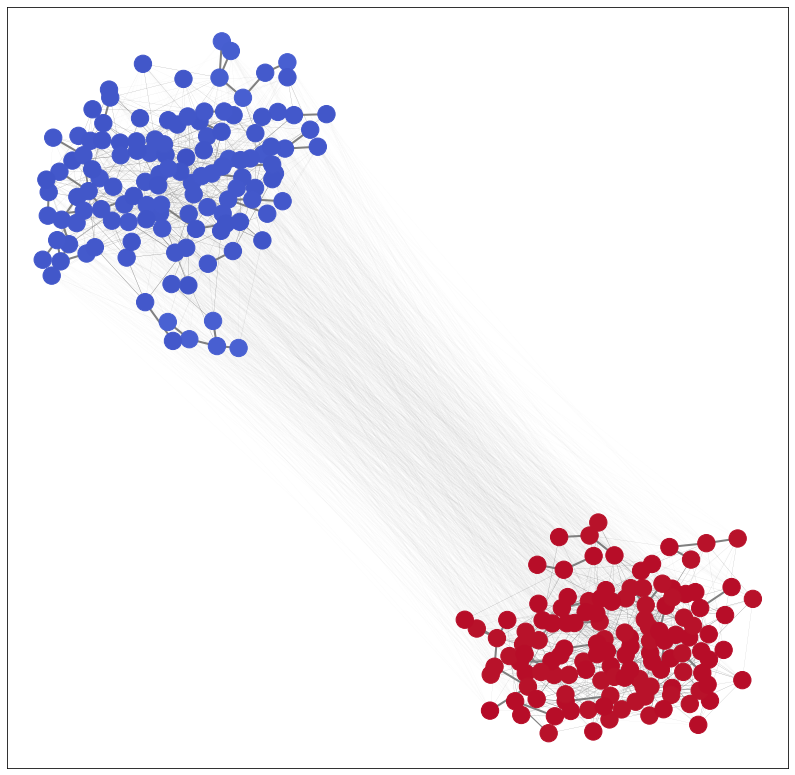

In [16]:
plt.figure(figsize=(14,14))

nc = nx.draw_networkx_nodes(G, pos, 
                            nodelist   = list(opinion_dic.keys()),
                            node_color = list(opinion_dic.values()) , 
                            cmap = plt.cm.coolwarm, vmin = -1, vmax = 1,)

ec = nx.draw_networkx_edges(G, pos, 
                            edgelist   = list(strength_dic.keys()),
                            edge_color = 'grey',
                            width      = np.array(list(strength_dic.values()))*2+0.01,)